In [1]:
# modelagem e dados
import torch
from torch import nn, optim

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt

# operações de imagem
import cv2

# outros
import os
import numpy as np
from tqdm import tqdm

In [2]:
from model.model_up_bilinear import SegNet, transforms
from dataset.dataloader import train_loader, val_loader, test_loader


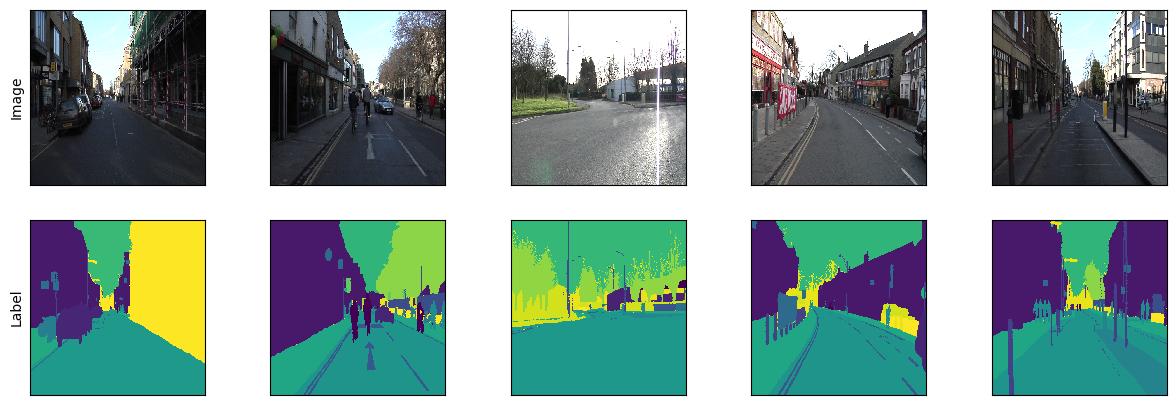

In [3]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))

ax[0][0].set_ylabel("Image")
ax[1][0].set_ylabel("Label")

for j in range(w):
    instances, targets = next(iter(train_loader))
    ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [10]:
model = SegNet().to(device)
model.load_state_dict(torch.load(r"model\weights\best_bilinear_whole_road.zip"))
summary(SegNet().to(device), (3, 224, 224), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
       BatchNorm2d-3          [1, 64, 224, 224]             128
            Conv2d-4          [1, 64, 224, 224]          36,928
              ReLU-5          [1, 64, 224, 224]               0
       BatchNorm2d-6          [1, 64, 224, 224]             128
         MaxPool2d-7          [1, 64, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]          73,856
              ReLU-9         [1, 128, 112, 112]               0
      BatchNorm2d-10         [1, 128, 112, 112]             256
           Conv2d-11         [1, 128, 112, 112]         147,584
             ReLU-12         [1, 128, 112, 112]               0
      BatchNorm2d-13         [1, 128, 112, 112]             256
        MaxPool2d-14           [1, 128,

In [6]:
train_losses = list()
valid_losses = list()

In [7]:
EPOCHS = 100
lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [8]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
  train_loss = 0
  for X, Y in loader:
    X = transforms(X)
    y_pred = model(X.to(device))
    loss = loss_fn(y_pred, Y.to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  return train_loss / len(loader)


def validation_step(model, loader, loss_fn, device) -> float:
  loss = 0
  with torch.no_grad():
    for X, Y in loader:
      X = transforms(X)
      y_pred = model(X.to(device))
      loss += loss_fn(y_pred, Y.to(device)).item()
  return loss / len(loader)

In [39]:
from tqdm import tqdm
from copy import deepcopy

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_losses.append(train_step(model, train_loader, loss_fn, optimizer, device))
    valid_losses.append(validation_step(model, val_loader, loss_fn, device))
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
    print("\fLoss: {}\n".format(valid_losses[-1]))
  return best_model

In [ ]:
best_model = train_model()

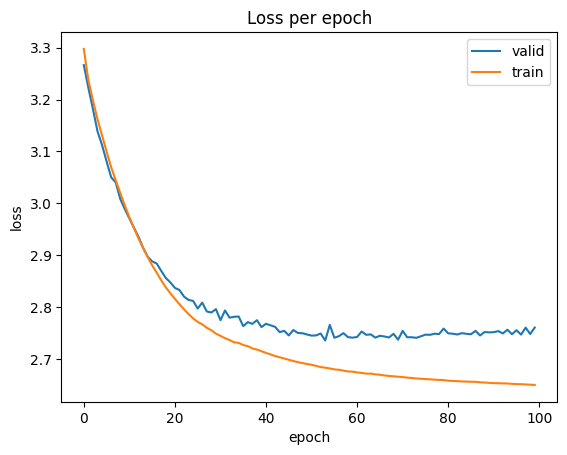

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

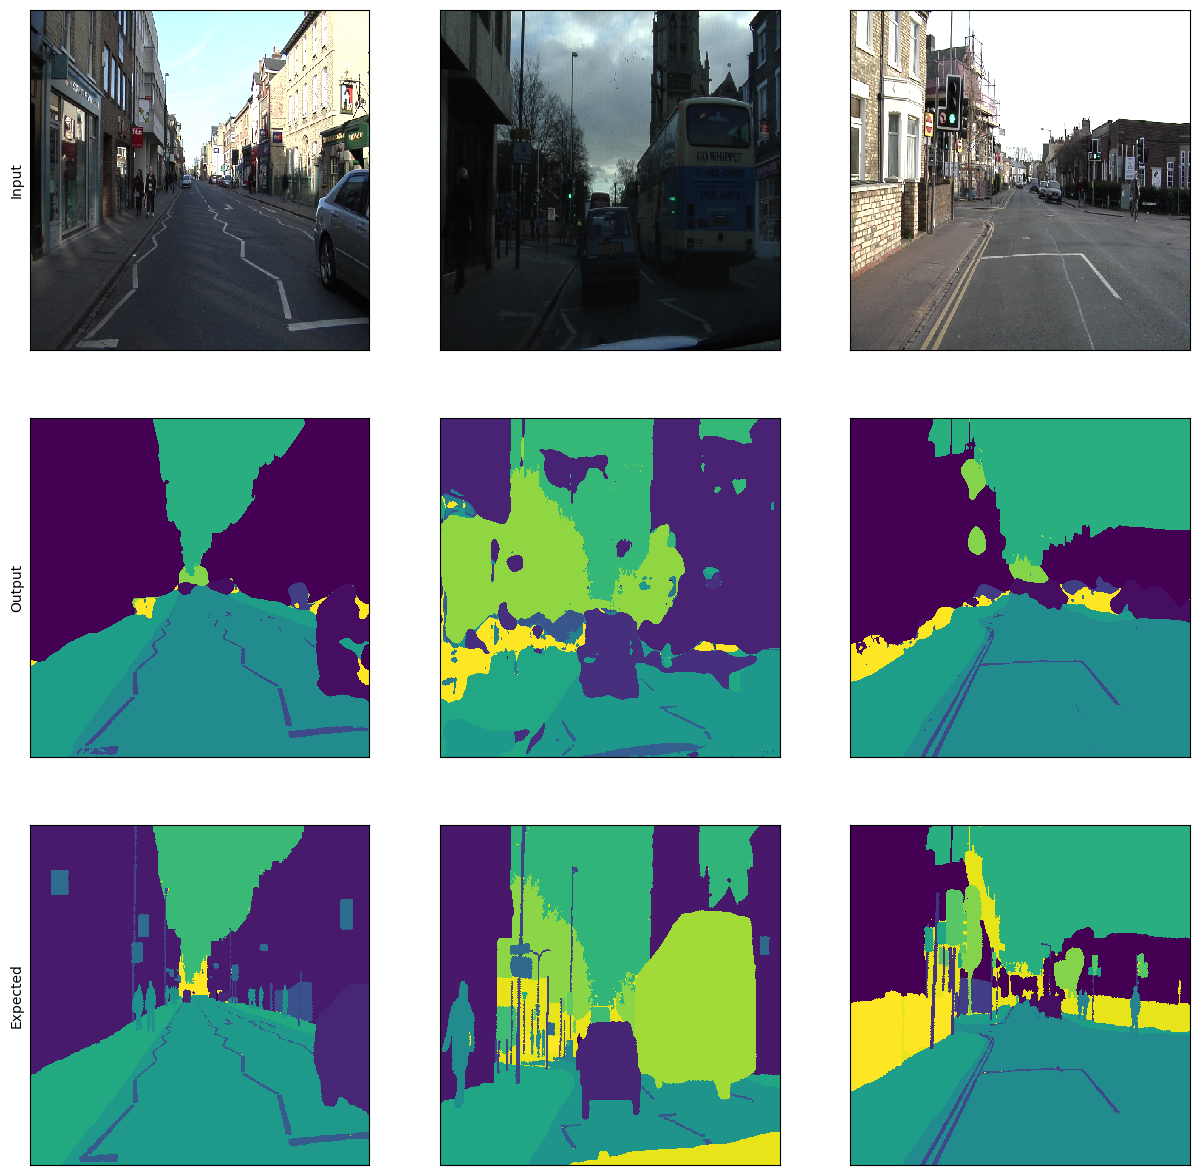

In [11]:
w = 3
fig, ax = plt.subplots(3, w, figsize=(15, 15))

ax[0][0].set_ylabel("Input")
ax[1][0].set_ylabel("Output")
ax[2][0].set_ylabel("Expected")
with torch.no_grad():
    for j in range(w):
        instances, targets = next(iter(test_loader))
        ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
        ax[0][j].set_xticks([])
        ax[0][j].set_yticks([])
        instances = transforms(instances)

        ax[1][j].imshow(torch.argmax(model(instances[0].to(device).unsqueeze(0)).squeeze(0).permute(1, 2, 0), dim=2).cpu().numpy().astype("uint8"), interpolation="None")
        ax[1][j].set_xticks([])
        ax[1][j].set_yticks([])

        ax[2][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
        ax[2][j].set_xticks([])
        ax[2][j].set_yticks([])

In [12]:
from utils.evaluation.multi_channel_iou import IoU
iou = IoU().to(device)

In [13]:
iou_test = torch.zeros([1, 34]).to(device)

for instances, targets in test_loader:
    instances = transforms(instances)
    predict = torch.zeros(targets.shape).to(device)
    res = torch.argmax(model(instances.to(device)), dim=-3)
    for ch in range(targets.shape[1]):
        predict[:, ch, :, :] = (res == ch)
    iou_test += iou(predict, targets.to(device))

iou_test /= len(test_loader)
iou_test

tensor([[5.5858e-01, 6.6806e-01, 7.8788e-01, 8.6147e-01, 3.9827e-01, 9.8701e-01,
         6.4600e-01, 4.3701e-01, 5.4978e-01, 8.1818e-01, 0.0000e+00, 1.3658e-01,
         4.4409e-01, 9.6970e-01, 1.4286e-01, 6.6234e-01, 6.0018e-02, 6.9264e-01,
         6.0606e-02, 8.3139e-01, 9.3939e-01, 5.8023e-01, 4.2424e-01, 8.6945e-01,
         3.8528e-01, 9.8268e-01, 1.6017e-01, 1.0000e+00, 5.5622e-01, 6.9698e-01,
         9.8268e-01, 5.7576e-01, 3.7919e-06, 2.3562e-01]], device='cuda:0')

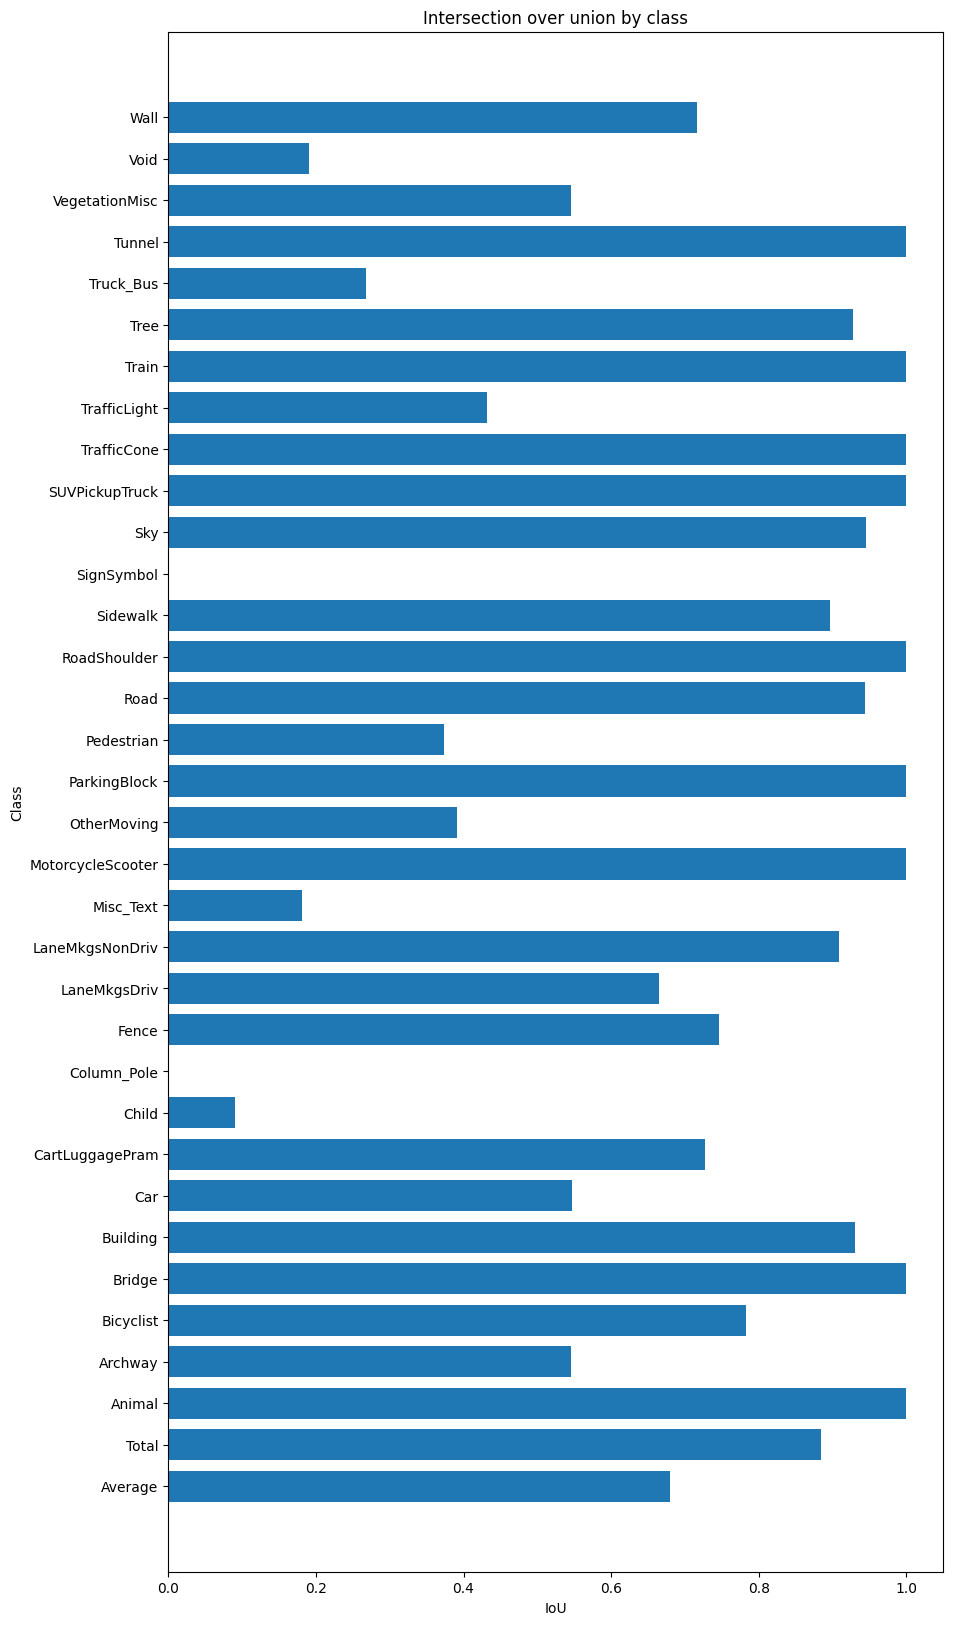

In [46]:
classes = ["Average", "Total", "Animal", "Archway", "Bicyclist", "Bridge", "Building", "Car", "CartLuggagePram", "Child", "Column_Pole", "Fence", "LaneMkgsDriv", "LaneMkgsNonDriv", "Misc_Text", "MotorcycleScooter", "OtherMoving", "ParkingBlock", "Pedestrian", "Road", "RoadShoulder", "Sidewalk", "SignSymbol", "Sky", "SUVPickupTruck", "TrafficCone", "TrafficLight", "Train", "Tree", "Truck_Bus", "Tunnel", "VegetationMisc", "Void", "Wall", ]
values = list(iou_test.squeeze().cpu().numpy())

fig = plt.figure(figsize = (10, 20))

plt.barh(classes, values, height=0.75)
 
plt.xlabel("IoU")
plt.ylabel("Class")
plt.title("Intersection over union by class")
plt.show()

In [47]:
to_save = False

if to_save:
    torch.save(model.state_dict(), r"model\weights\best_bilinear_road.zip")